## GPU Accelerated Interpretable Machine Learning for Diversified Portfolio Construction

In this notebook, we accelerated a pipeline to benchmark Hierarchical Risk Parity (HRP) relative to Naive Risk Parity (NRP) in the GPU as described in the [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3730144). It is an example of diversification strategy allocating to liquid multi-asset futures markets with dynamic leverage ("volatility target"). This workflow includes following steps:

* Load csv data of asset daily prices
* Run block bootstrap to generate 100k different scenarios.
* Compute the log returns for each scenario. 
* Compute assets distances to run hierarchical clustering and Hierarchical Risk Parity (HRP) weights for the assets
* Compute the weights for the assets based on the Naïve Risk Parity (NRP) method.
* Compute the transaction cost based on weights adjustment on the rebalancing days
* At every rebalancing date, calculate the portfolio leverage to reach the volatility target.
* Compute the Average annual Returns, Std Returns, Sharpe Ratios, Maximum Drawdown, and Calmar Ratio performance metrics for these two methods (HRP-NRP)

## Background

**Naive Risk Parity**  Naive Risk Parity (NRP), is here called naive because it ignores the correlation among the assets. In an RP portfolio, an asset weight is indirectly proportional to its historical volatility as explained in Roncalli (2013). More formally, the weight $w_i$ for the i-thasset with i spanning the portfolio universe $i =1,...,N$ is
$$ w_i = \frac{\sigma_i^{-1}}{\sum_{j}\sigma_j^{-1}}$$
where $\sigma_i = \sqrt{\sum_{ii}}$ denotes the volatility of asset i.

**HRP** The standard HRP approach (Lopez de Prado (2016a)) uses a tree clustering algorithm to perform a quasi-diagonalization of the covariance matrix. After the quasi-diagonalization is carried out, a recursive bi-sectioning method is used to define the weights of each asset within the portfolio. The following dendogram shows the top 13 companies by global market cap clustered by the tree clustering algorithm. Notice how financial stocks such as Bank of America and JPMorgan are clustered together. Same happens for Asian stocks (Tencent and Alibaba) or IT giants (Google, Amazon, Facebook). 

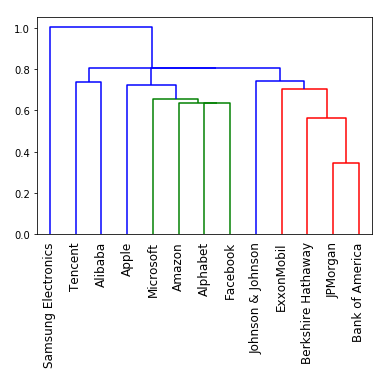

**Performance metrics**

Statistics | Short | Description
--- | --- | ----
Volatility | SD | Annualized volatility
Returns | RET | Annualized returns
Maximum Drawdown | MDD | Drawdowns percentage
Sharpe ratio | SR | The ratio between returns and volatility (annualized)
Calmar Ratio | Calmar | The ratiobetweenannualizedreturns and max drawdown


**Backtests**
The strategies are rebalanced every month. At every rebalancing date, the portfolio leverage is set to reach the volatility target of $\sigma_{target} = 5\%$ annualized in a hindsight. The portfolio leverage
determines the total market value of the portfolio and thus the position quantities of each instrument. The estimation of realized volatility used for the updated leverage number is the
maximum of the volatilities of the portfolio measured over 20 and 60 trading days, respectively $\sigma_{t=20}$ and $\sigma_{t=60}$.  The target weight is calculated as
$$W_{target} = \frac{\sigma_{target}} {\max(\sigma_{t=20}, \sigma_{t=60})}$$

Start the Dask cluster for distributed computation

In [1]:
# run this cell if you need Dask
from dask_cuda import LocalCUDACluster
import dask
dask.config.set({"distributed.comm.timeouts.tcp": "90s"})
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:43289 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 503.80 GiB


## Results for the empirical dataset 

Following is the workflow from CSV data loading to backtest performance metrics computation. 

In [2]:
import cupy
import cudf
import matplotlib.pyplot as pl
from greenflow.dataframe_flow import TaskGraph
from IPython.display import display, HTML
taskGraph=TaskGraph.load_taskgraph('./17assets/workflow_empirical.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', 'load_raw_csv'), ('type', 'LoadCsvNode'), ('conf', {'cs…

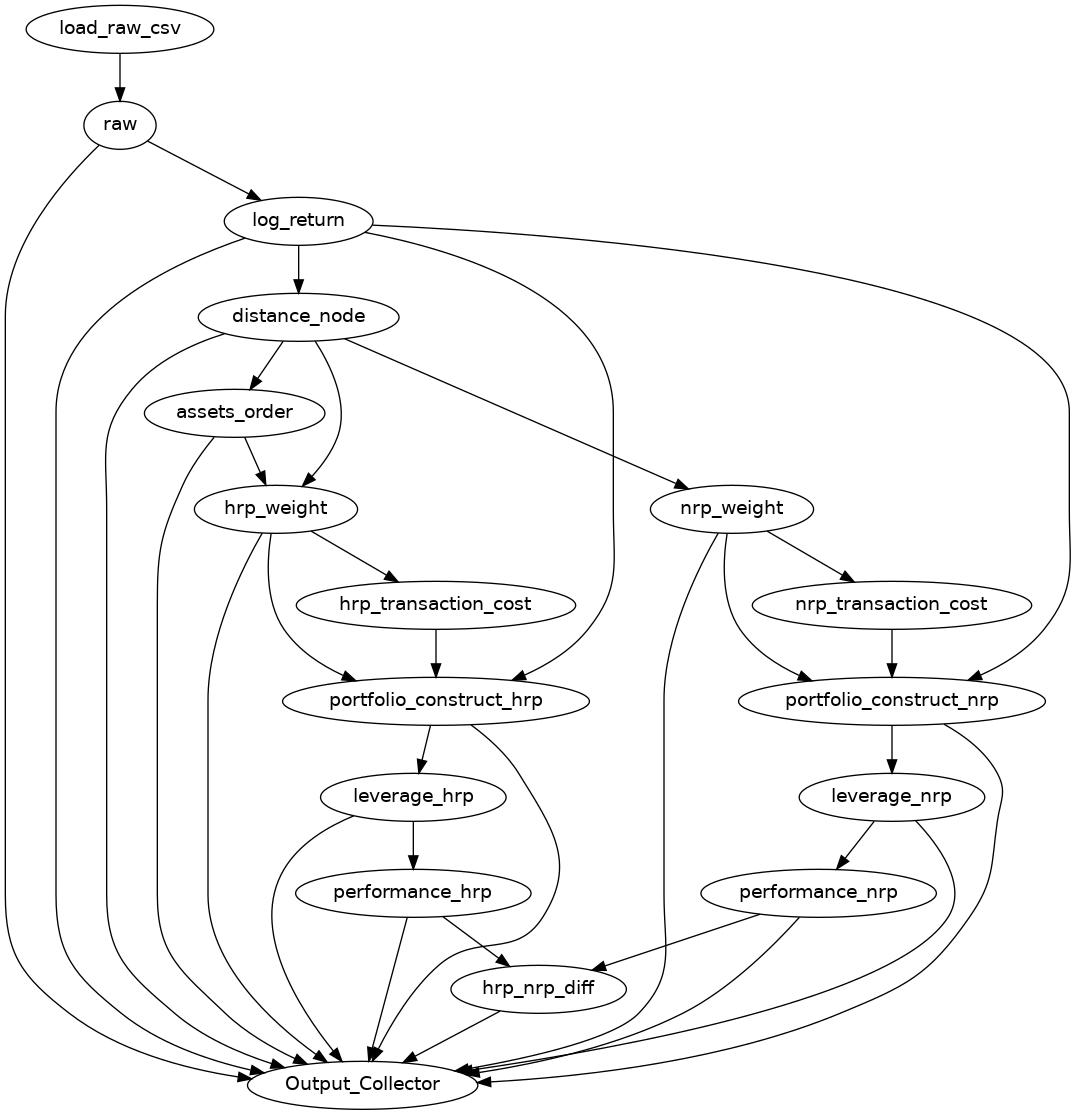

In [3]:
taskGraph.draw(show='ipynb')

We can run the workflow by clicking on the button in the widget or we can run following command. The result will be saved in the `result` variable

In [4]:
result = taskGraph.run()

All the intermediate result can be fetched by the keys of `result` variable. We can list all the keys by running: 

In [5]:
result.get_keys()

('hrp_nrp_diff.out',
 'raw.out',
 'log_return.out',
 'assets_order.out',
 'hrp_weight.out',
 'portfolio_construct_hrp.out',
 'portfolio_construct_nrp.out',
 'nrp_weight.out',
 'distance_node.cov_df',
 'distance_node.distance_df',
 'leverage_hrp.lev_df',
 'leverage_nrp.lev_df',
 'performance_nrp.calmar_df',
 'performance_hrp.calmar_df',
 'performance_nrp.sharpe_df',
 'performance_nrp.sd_df',
 'performance_nrp.ret_df',
 'performance_nrp.maxdd_df',
 'performance_hrp.ret_df',
 'performance_hrp.sd_df',
 'performance_hrp.sharpe_df',
 'performance_hrp.maxdd_df')

Let's plot the empirical dataset strategies performances

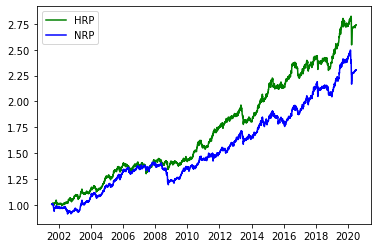

In [6]:
date = result['leverage_nrp.lev_df'].sort_index()['date'].values.get()
pl.plot(date, cupy.exp(cupy.cumsum(result['leverage_hrp.lev_df'].sort_index()['portfolio'].values)).get(), color='g', label='HRP')
pl.plot(date, cupy.exp(cupy.cumsum(result['leverage_nrp.lev_df'].sort_index()['portfolio'].values)).get(), color='b', label='NRP')
pl.legend()

Organize all the performance metrics in a table

In [7]:
nrp_metrics = [result['performance_nrp.sd_df']['portfolio'].values.item(),
               result['performance_nrp.ret_df']['portfolio'].values.item(),
               result['performance_nrp.maxdd_df']['portfolio'].values.item(),
               result['performance_nrp.calmar_df']['portfolio'].values.item(),
               result['performance_nrp.sharpe_df']['portfolio'].values.item()]
hrp_metrics = [result['performance_hrp.sd_df']['portfolio'].values.item(),
               result['performance_hrp.ret_df']['portfolio'].values.item(),
               result['performance_hrp.maxdd_df']['portfolio'].values.item(),
               result['performance_hrp.calmar_df']['portfolio'].values.item(),
               result['performance_hrp.sharpe_df']['portfolio'].values.item()]
metrics = ['SD', 'RET', 'MDD', 'Calmar', 'SR']
df = cudf.DataFrame({'metrics': metrics, 'NRP': nrp_metrics, 'HRP': hrp_metrics})
df.set_index('metrics')

,NRP,HRP
metrics,,
SD,0.053235,0.051569
RET,0.045118,0.054740
MDD,0.155329,0.098149
Calmar,0.290464,0.557726
SR,0.847511,1.061491


## Robustness of the strategies

Bootstrapped dataset To account for the non-stationarity of futures return time series, we generate an additional dataset of time-series by block bootstrapping (Hall (1985), Carlstein and others(1986), Fengler and Schwendner(2004) and Lohre, Rother, and Schaefer (2020)):

* Blocks with a fixed length, but a random starting point in time are defined from the futures return time-series. One block corresponds to 60 business days. This block length is motivated by a typical monthly or quarterly rebalancing frequency of dynamic rule-based strategies and by the empirical market dynamics that happen on this time scale. Papenbrock and Schwendner (2015) found multi-asset correlation patterns to change at a typical frequency of a few months.
* A new return time-series is constructed by sampling the blocks with replacement to reconstruct a time-series with the same length of the original time-series. 

We added a Bootstrap Node to accelerate the bootstrap computation in the GPU. Run 4096 bootstrap samples, we can build a distribution of the performance metrics. Following is the workflow of running the bootstrap.

In [8]:
taskGraph=TaskGraph.load_taskgraph('./17assets/workflow_bootstrap.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', 'load_raw_csv'), ('type', 'LoadCsvNode'), ('conf', {'cs…

Collect the results and list all the result keys:

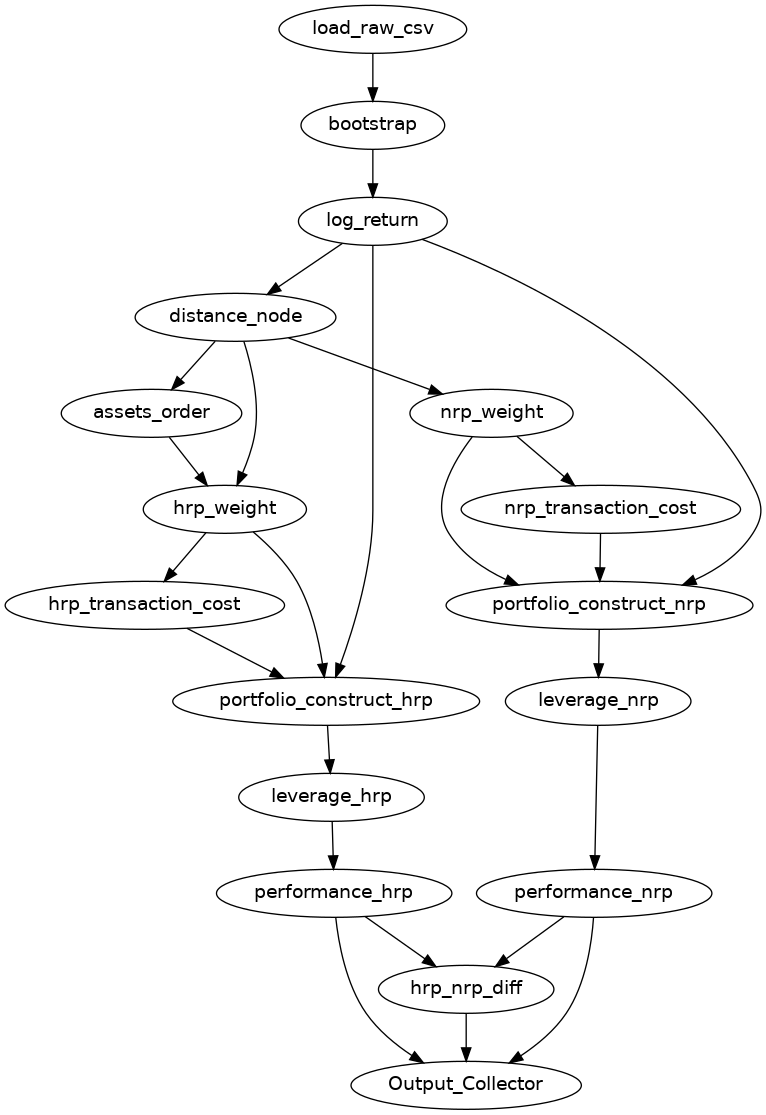

In [9]:
taskGraph.draw(show='ipynb')

In [10]:
result = taskGraph.run()
result.get_keys()

('hrp_nrp_diff.out',
 'performance_nrp.ret_df',
 'performance_nrp.sd_df',
 'performance_nrp.sharpe_df',
 'performance_hrp.ret_df',
 'performance_hrp.sd_df',
 'performance_hrp.sharpe_df',
 'performance_hrp.maxdd_df',
 'performance_nrp.calmar_df',
 'performance_hrp.calmar_df',
 'performance_nrp.maxdd_df')

Draw the performance statistics distribution:

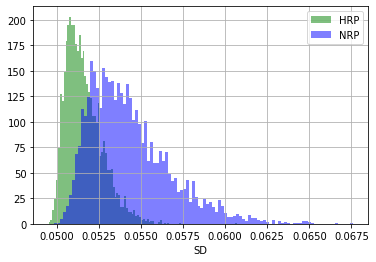

In [11]:
result['performance_hrp.sd_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.sd_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('SD')
pl.legend()

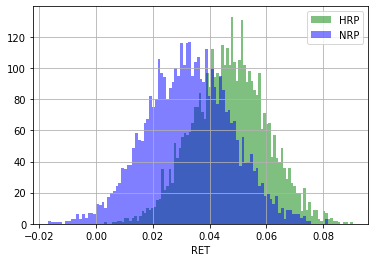

In [12]:
result['performance_hrp.ret_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.ret_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('RET')
pl.legend()

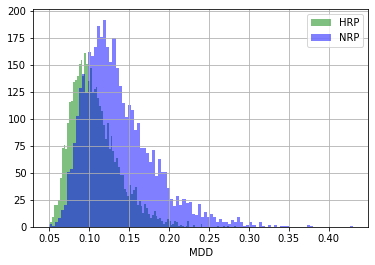

In [13]:
result['performance_hrp.maxdd_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.maxdd_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('MDD')
pl.legend()

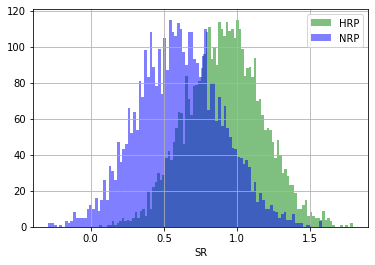

In [14]:
result['performance_hrp.sharpe_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.sharpe_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('SR')
pl.legend()

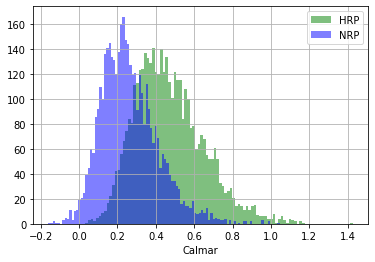

In [15]:
result['performance_hrp.calmar_df'].to_pandas()['portfolio'].hist(bins=100, color='g', alpha=.5, label='HRP')
result['performance_nrp.calmar_df'].to_pandas()['portfolio'].hist(bins=100, color='b', alpha=.5, label='NRP')
pl.xlabel('Calmar')
pl.legend()

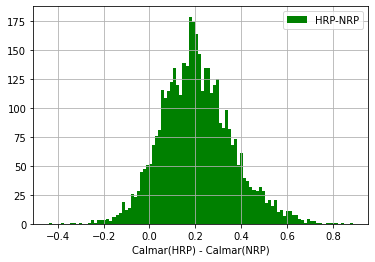

In [16]:
result['hrp_nrp_diff.out'].to_pandas()['portfolio'].hist(bins=100, color='g', label='HRP-NRP')
pl.xlabel('Calmar(HRP) - Calmar(NRP)')
pl.legend()

## Interpretable Machine Learning
In this section, we train a supervised learning model to fit the spread between the Calmar ratios of HRP and the NRP using statistical features of the bootstrapped
datasets. 

**The features**

To characterize the portfolio universe, we select a set of classical statistical features plus a set of quantities that can indicate properties of the hierarchical structure of the asset universe. This particular set of features is tailored to both strategies, and without the help of ML it would be quite difficult to link them to the performances of the strategies. We also look at some features that encode non-stationarity properties. Whenever the feature name has the suffix `_std`., we measure the standard deviation of the statistical property across time. That helps to identify the heterogeneity of that property across the years. 

In total, we use 30 features associated with the portfolio universe. For example, X_mean_mean identifies the mean across assets of the mean returns across time. In other words, it provides information regarding the overall trend of the returns of the full portfolio. The `X_mean_mean_std` instead represents how the overall trend changes across years and is measured by the standard deviation of the `X_mean_means` measured year by year. Another feature is `X_mean_std` that measures the heterogeneity of the returns across the assets. A high value of this quantity means that the overall trend of the returns is characterized by a very heterogeneous behaviour across assets (in general features that have names ending with `X_std` have been measured with the standard deviation of X across assets).  `corr_mean` is the mean of the entries of the correlation matrix (only the lower diagonal terms) and together with `corr_std` (their standard deviation) they provide information on the independence of the asset from the rest of the universe. For example, a negative value of `corr_mean` suggests that there is a high number of assets that are anti-correlated. A value close to zero can represent either a portfolio with independent assets or one with the same degree of positive and negative correlations. In this case, `corr_std` would discriminate between the two possibilities. 

Following is the workflow to calculate all the features for each bootstrap sample in the GPU

In [17]:

taskGraph=TaskGraph.load_taskgraph('./17assets/feature_computation_workflow.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', 'load_raw_csv'), ('type', 'LoadCsvNode'), ('conf', {'cs…

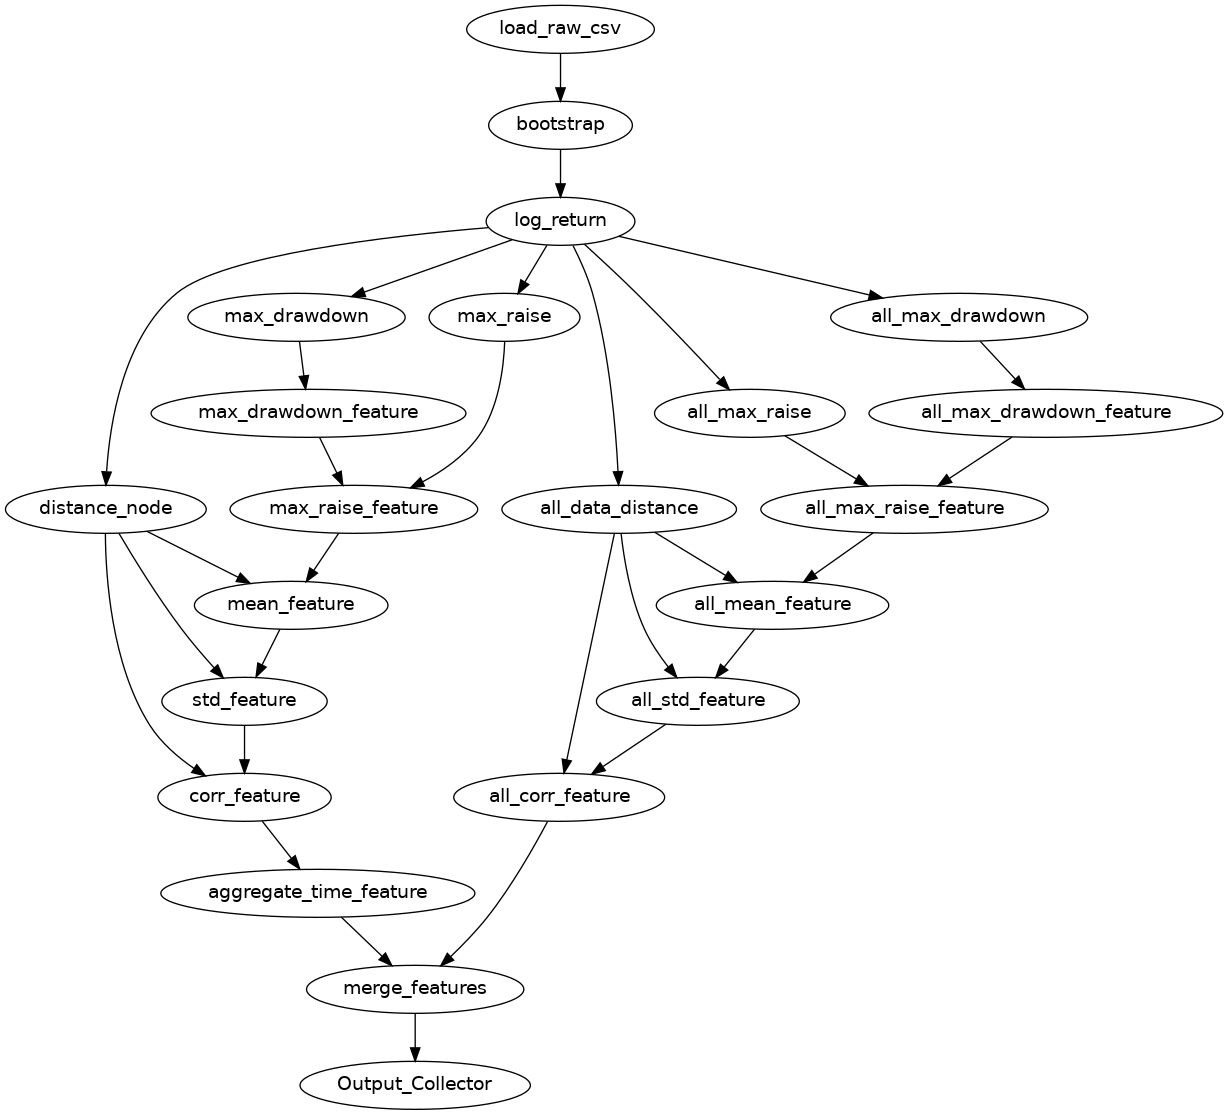

In [18]:
taskGraph.draw(show='ipynb')

In [19]:
del result
result = taskGraph.run()
result['merge_features.merged']

,sample_id,max_drawdown_mean_mean,max_drawdown_std_mean,max_raise_mean_mean,max_raise_std_mean,mean_mean_mean,mean_std_mean,std_mean_mean,std_std_mean,corr_mean_mean,...,all_max_drawdown_mean,all_max_drawdown_std,all_max_raise_mean,all_max_raise_std,all_mean_mean,all_mean_std,all_std_mean,all_std_std,all_corr_mean,all_corr_std
0,381,0.165513,0.108867,0.173959,0.089046,0.000056,0.000618,0.011322,0.006126,-1.337516,...,0.456234,0.265472,0.651103,0.110955,0.000083,0.000161,0.012090,0.006492,-1.327829,0.739377
1,1163,0.170721,0.107431,0.185890,0.088455,0.000094,0.000633,0.011545,0.006176,-1.338875,...,0.541878,0.302561,0.745563,0.102035,0.000114,0.000141,0.011972,0.006140,-1.310273,0.706726
2,3488,0.201196,0.133484,0.178988,0.085566,-0.000160,0.000745,0.012348,0.007142,-1.345710,...,0.589633,0.339682,0.644930,0.092962,-0.000179,0.000378,0.013083,0.007267,-1.309862,0.694872
3,1178,0.175798,0.116084,0.181123,0.086872,0.000024,0.000626,0.012057,0.006978,-1.325626,...,0.482604,0.289598,0.682790,0.061548,0.000026,0.000240,0.012494,0.006947,-1.281249,0.667939
4,3271,0.176976,0.104699,0.180854,0.091652,0.000049,0.000603,0.011670,0.006245,-1.307143,...,0.526866,0.268432,0.618936,0.095054,0.000044,0.000103,0.012150,0.006139,-1.290354,0.670003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,1605,0.192972,0.121567,0.192663,0.090775,-0.000047,0.000840,0.012691,0.007287,-1.347182,...,0.632730,0.323558,0.701390,0.124733,-0.000056,0.000414,0.013342,0.007441,-1.302273,0.694651
4092,2583,0.189980,0.117157,0.190388,0.095698,0.000005,0.000690,0.012742,0.007406,-1.353827,...,0.494272,0.277220,0.593790,0.149085,0.000050,0.000184,0.013177,0.007419,-1.313642,0.700307
4093,3507,0.178070,0.107444,0.177590,0.085778,-0.000002,0.000631,0.011756,0.006303,-1.327630,...,0.465006,0.247158,0.578809,0.144253,0.000030,0.000254,0.012019,0.006164,-1.291822,0.686415
4094,966,0.172711,0.111441,0.174926,0.084973,0.000018,0.000642,0.011721,0.006507,-1.316751,...,0.459094,0.270003,0.594811,0.130578,0.000043,0.000232,0.012007,0.006453,-1.284322,0.673489


The taskgrpah is a bit complicated, we can use `CompositeNode` to group the sub-graph into a single node. Here is a simplified version of it:

In [20]:
taskGraph=TaskGraph.load_taskgraph('./17assets/all_feature_simplified.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

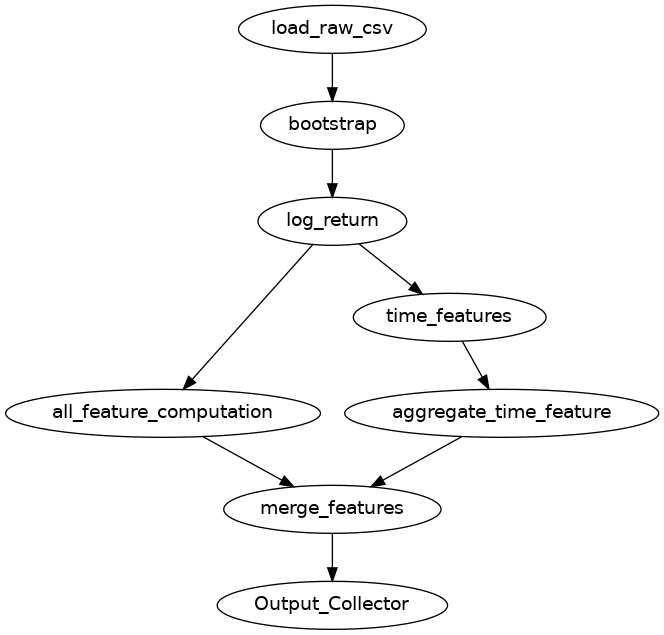

In [21]:
taskGraph.draw(show='ipynb')

In [22]:
del result
result = taskGraph.run()
result['merge_features.merged']

,sample_id,max_drawdown_mean_mean,max_drawdown_std_mean,max_raise_mean_mean,max_raise_std_mean,mean_mean_mean,mean_std_mean,std_mean_mean,std_std_mean,corr_mean_mean,...,all_max_drawdown_mean,all_max_drawdown_std,all_max_raise_mean,all_max_raise_std,all_mean_mean,all_mean_std,all_std_mean,all_std_std,all_corr_mean,all_corr_std
0,4039,0.161152,0.099517,0.199849,0.098209,0.000264,0.000629,0.011589,0.006199,-1.329793,...,0.398502,0.214816,0.772228,0.156009,0.000265,0.000191,0.011872,0.006092,-1.305161,0.715279
1,3403,0.172405,0.103150,0.199323,0.102338,0.000197,0.000593,0.011766,0.006638,-1.321531,...,0.452941,0.249063,0.699393,0.169047,0.000202,0.000131,0.012113,0.006680,-1.285092,0.669527
2,1058,0.158491,0.095144,0.178136,0.090195,0.000129,0.000556,0.010577,0.005622,-1.342557,...,0.424646,0.233942,0.630786,0.138848,0.000121,0.000088,0.010731,0.005504,-1.321394,0.701067
3,1760,0.169325,0.095756,0.197750,0.103289,0.000201,0.000654,0.011904,0.006260,-1.327755,...,0.520696,0.212860,0.703013,0.228784,0.000215,0.000151,0.012198,0.006131,-1.307005,0.721012
4,160,0.147343,0.093246,0.185785,0.095550,0.000254,0.000594,0.010561,0.005641,-1.358376,...,0.397904,0.227736,0.783330,0.119623,0.000249,0.000149,0.010827,0.005616,-1.338735,0.724873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,1605,0.167846,0.110767,0.179824,0.094349,0.000075,0.000619,0.011619,0.006603,-1.353803,...,0.518682,0.309170,0.653841,0.132726,0.000058,0.000196,0.012421,0.006972,-1.319323,0.694665
4092,2583,0.157441,0.100187,0.178871,0.099672,0.000150,0.000666,0.011054,0.005920,-1.330616,...,0.460182,0.226944,0.671735,0.169644,0.000138,0.000103,0.011244,0.005750,-1.318194,0.689344
4093,3507,0.174698,0.109942,0.172970,0.089219,-0.000008,0.000667,0.011046,0.006143,-1.330879,...,0.540392,0.277093,0.629053,0.103970,0.000013,0.000168,0.011512,0.006169,-1.311932,0.673679
4094,966,0.167673,0.102540,0.179725,0.094430,0.000084,0.000624,0.011211,0.006044,-1.307982,...,0.487666,0.272334,0.659308,0.178123,0.000075,0.000153,0.011527,0.005942,-1.285804,0.662960


## The ML learning model

For the supervised learning algorithm, we selected XGBoost (Chen and Guestrin (2016)) , a gradient tree boosting library that is fast and accurate as described in the paper. This algorithm can construct non-linear relations among the features. Moreover, for large datasets, it can scale across GPUs to speed-up the learning process. Another benefit of using XGBoost is that it produces fast explanations.

To assess the stability of the explanations, the set of bootstrapped datasets, each across 17 multi-asset futures, is split into 90% training and 10% test set. We trained the model as a regression, to learn the difference between the Calmarratio obtained with HRP minus the Calmar ratio obtained by HRP. 

In [23]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
# run this cell if you need Dask
from dask_cuda import LocalCUDACluster
import dask
dask.config.set({"distributed.comm.timeouts.tcp": "90s"})
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:34124 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 503.80 GiB


In [2]:
import cupy
import cudf
import matplotlib.pyplot as pl
from greenflow.dataframe_flow import TaskGraph
from IPython.display import display, HTML

In [3]:
taskGraph=TaskGraph.load_taskgraph('./17assets/xgboost_performance.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

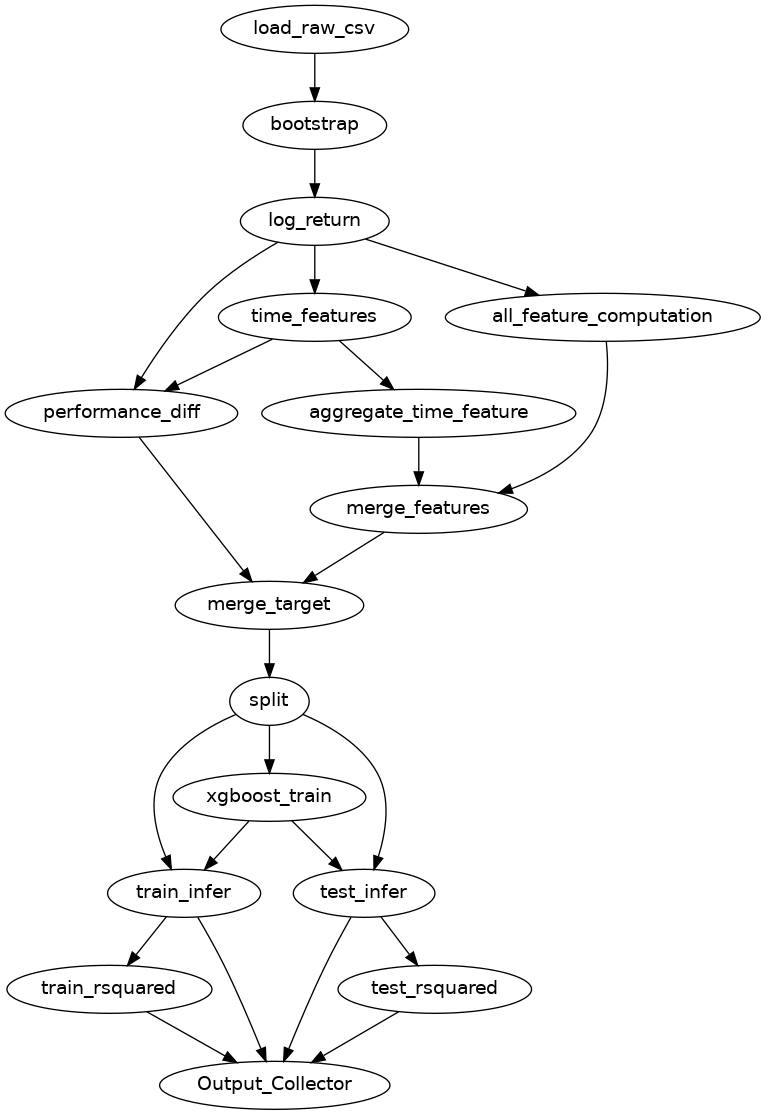

In [4]:
taskGraph.draw(show='ipynb')

Run and collect the results:

In [5]:
result = taskGraph.run()

Let's check the R-squared score for both Train dataset and Test dataset

In [6]:
print('Train R-Squared:', result['train_rsquared.out'], 'Test R-Squared:', result['test_rsquared.out'])

Train R-Squared: 0.9996281424524893 Test R-Squared: 0.17305883654610676


Text(0.5, 1.0, 'Test')

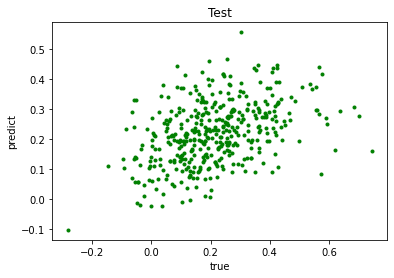

In [7]:
pl.plot(result['test_infer.out'].portfolio.values.get(), result['test_infer.out'].predict.values.get(), 'g.')
pl.xlabel('true')
pl.ylabel('predict')
pl.title('Test')

Text(0.5, 1.0, 'Train')

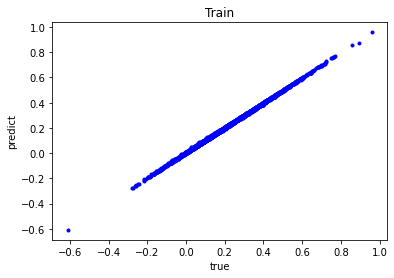

In [8]:
pl.plot(result['train_infer.out'].portfolio.values.get(), result['train_infer.out'].predict.values.get(), 'b.')
pl.xlabel('true')
pl.ylabel('predict')
pl.title('Train')

Clearly the XGBoost model is overfitted as we only use 4096 datapoints. We will use more datapoints later

## The explanation method

We will use Shapley values of feature contribution to explain the ML result. In simple words, what Shapley values tell us is how much each feature (the statistical properties ofthe asset universe described above) has contributed to a specific outcome of theML model. Because of the complexity (non-linearity) of the model, this is a non-trivial task. The Shapley value is a quantity introduced in co-operative game theory to provide the fair payout to a player (the features) with respect to its contribution to the common goal (ML prediction). The SHAP framework (Lundberg and Lee (2017)) provides a tool to evaluate this quantity even in a model agnostic way. It allows comparing these quantitative explanations among different models.

Shapley values can be computed from the XGboost inference node. Following is the workflow to visualize the feature contributions. 

In [9]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
# run this cell if you need Dask
from dask_cuda import LocalCUDACluster
import dask
dask.config.set({"distributed.comm.timeouts.tcp": "90s"})
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:39020 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 503.80 GiB


In [2]:
import cupy
import cudf
import matplotlib.pyplot as pl
from greenflow.dataframe_flow import TaskGraph
from IPython.display import display, HTML

In [3]:
taskGraph=TaskGraph.load_taskgraph('./17assets/xgboost_shap.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

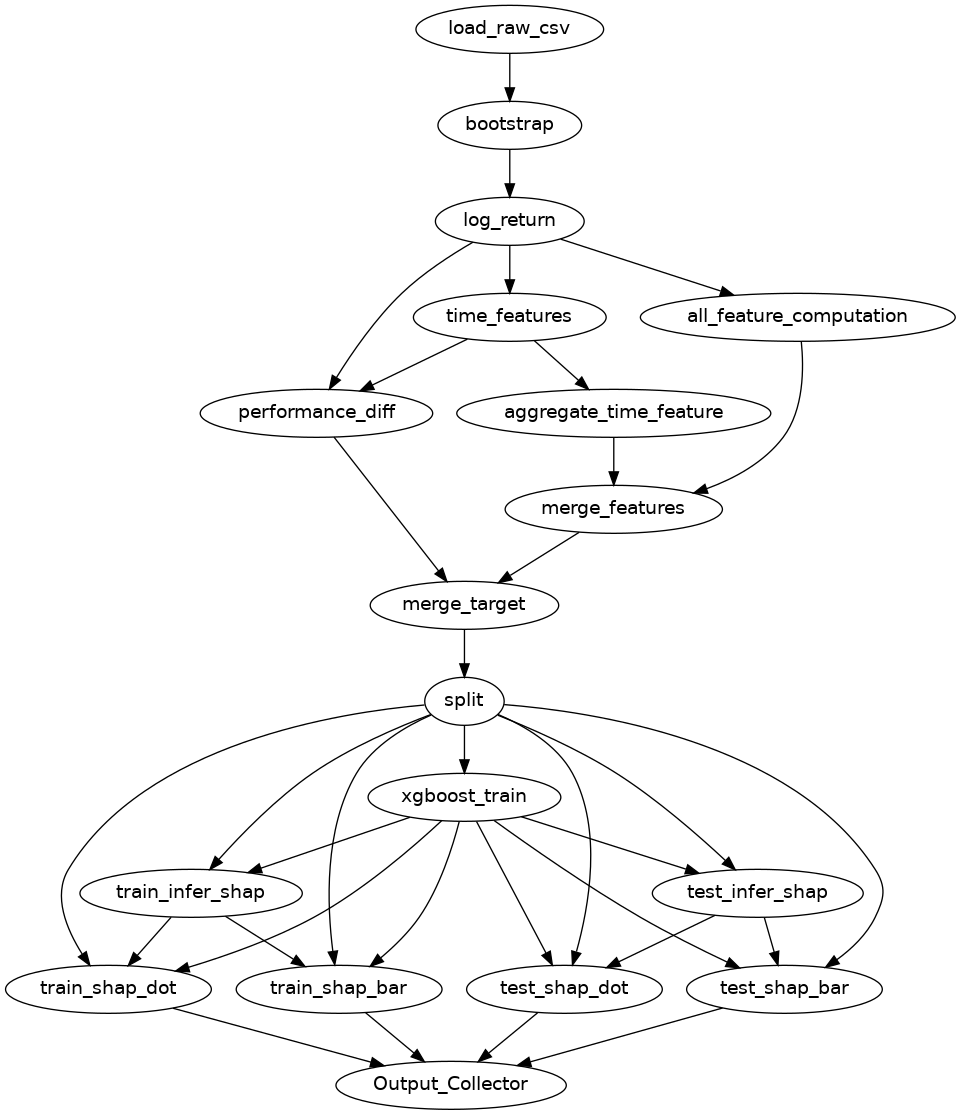

In [4]:
taskGraph.draw(show='ipynb')

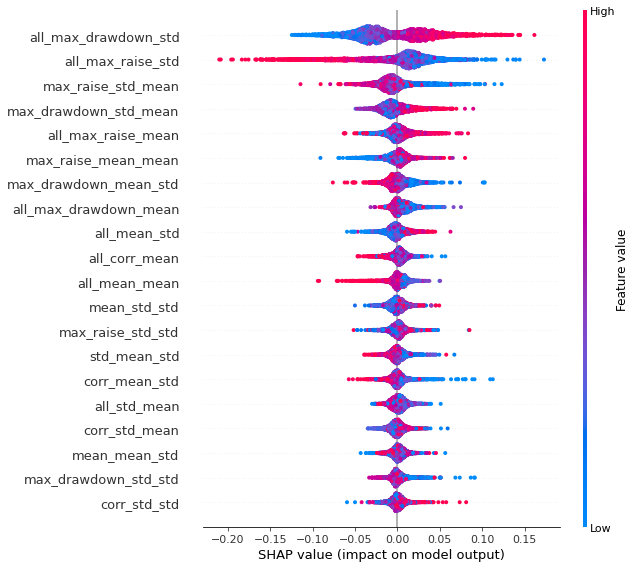

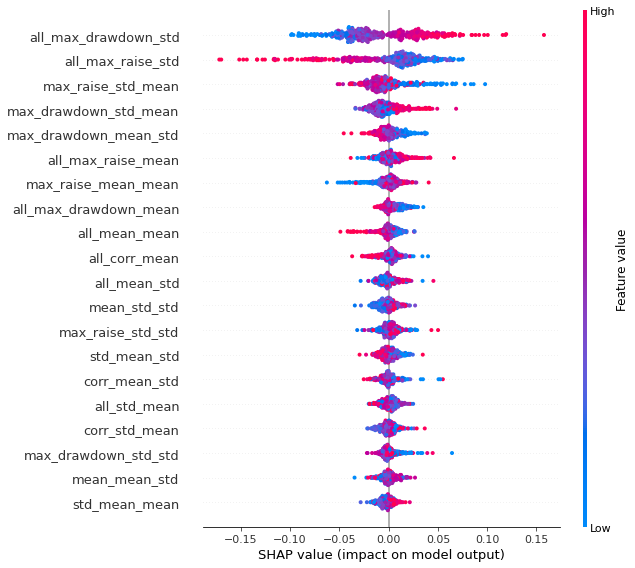

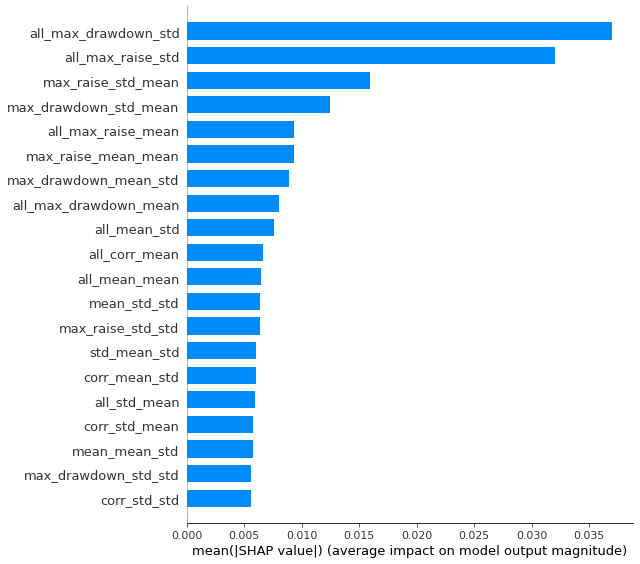

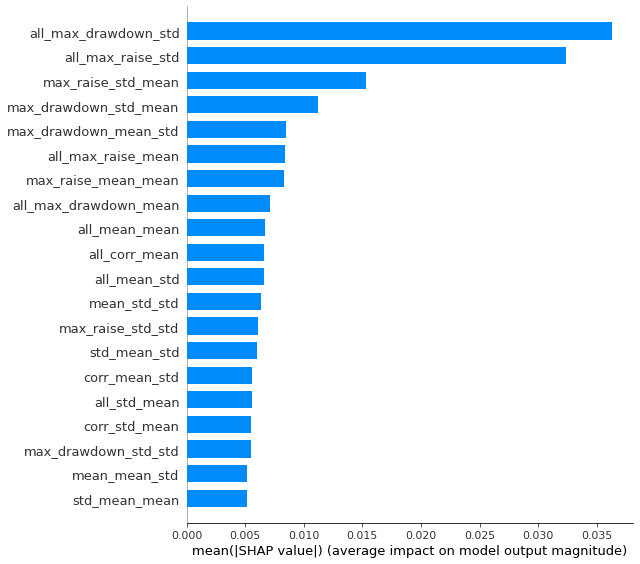

In [5]:
result = taskGraph.run()

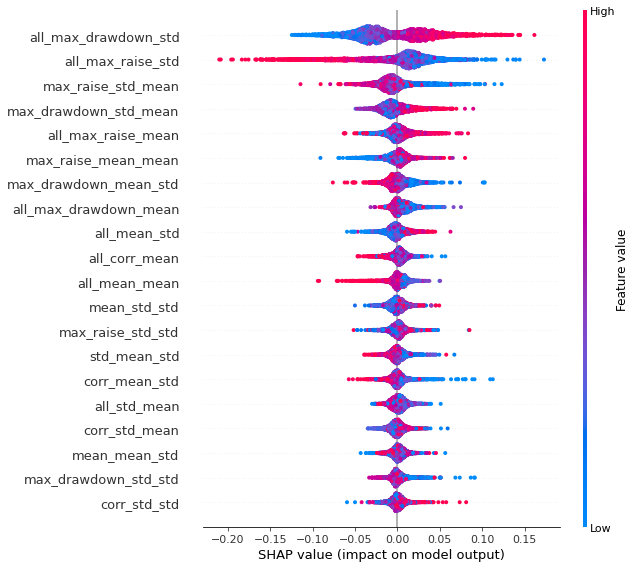

In [6]:
display(HTML('<h1>Shap Summary, Train</h1>'))
result['train_shap_dot.summary_plot']

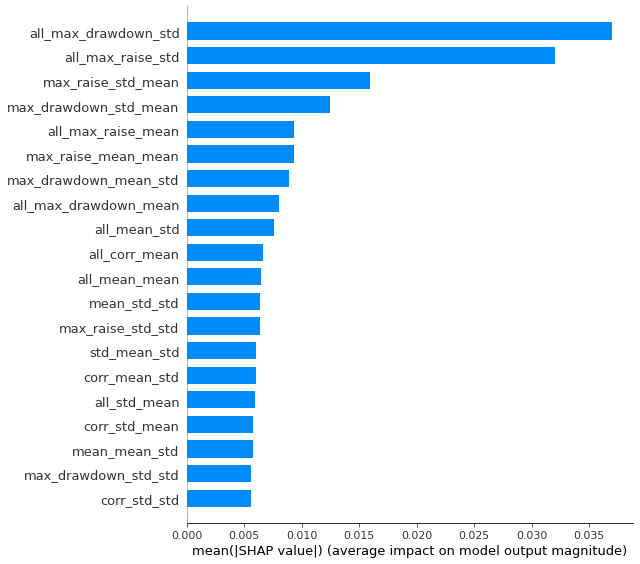

In [7]:
display(HTML('<h1>Shap Summary, Train</h1>'))
result['train_shap_bar.summary_plot']

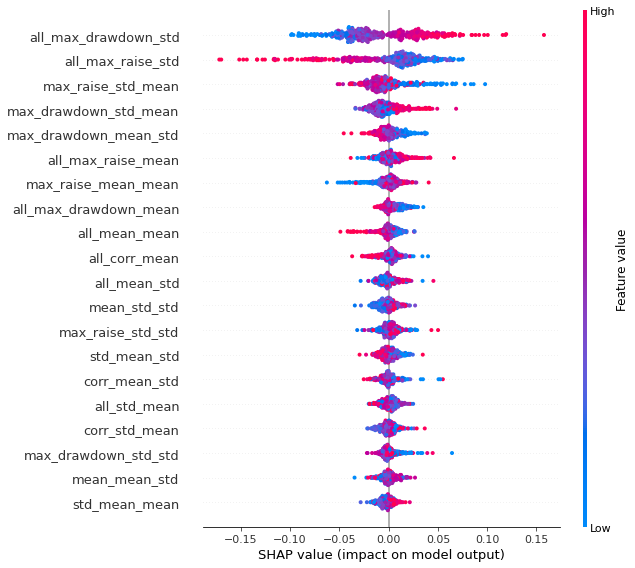

In [8]:
display(HTML('<h1>Shap Summary, Test</h1>'))
result['test_shap_dot.summary_plot']

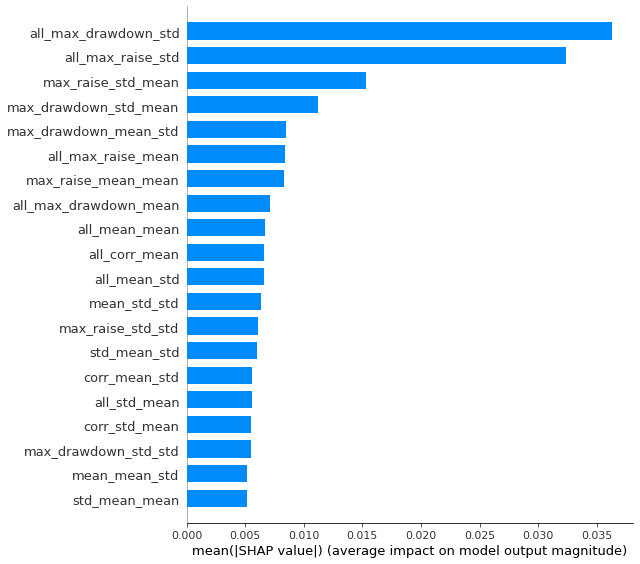

In [9]:
display(HTML('<h1>Shap Summary, Test</h1>'))
result['test_shap_bar.summary_plot']

## Scale to 100K Samples

The maximum number of samples that can be computed in a single 32G V100 GPU is 4096. To compute 100K samples, we use Dask to distribute the workloads in multiple GPUs.


In [10]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
# run this cell if you need Dask
from dask_cuda import LocalCUDACluster
import dask
dask.config.set({"distributed.comm.timeouts.tcp": "90s"})
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:35782 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 503.80 GiB


In [2]:
import cupy
import cudf
import matplotlib.pyplot as pl
from greenflow.dataframe_flow import TaskGraph
from IPython.display import display, HTML

In [3]:
taskGraph=TaskGraph.load_taskgraph('./17assets/parallel_xgboost_shap.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

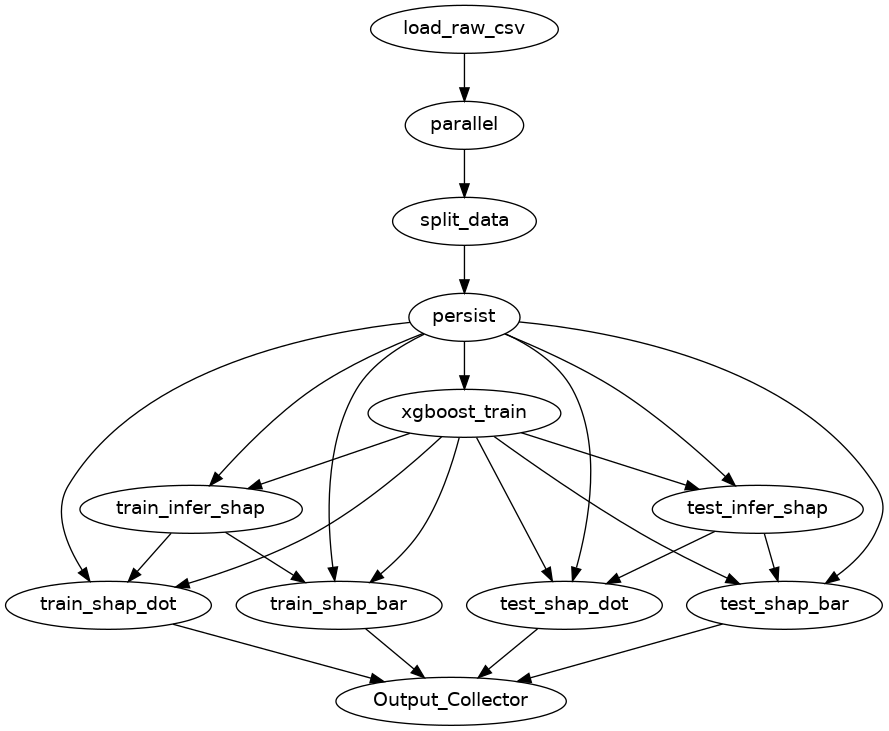

In [4]:
taskGraph.draw(show='ipynb')

CPU times: user 19.5 s, sys: 3.44 s, total: 22.9 s
Wall time: 2min 52s


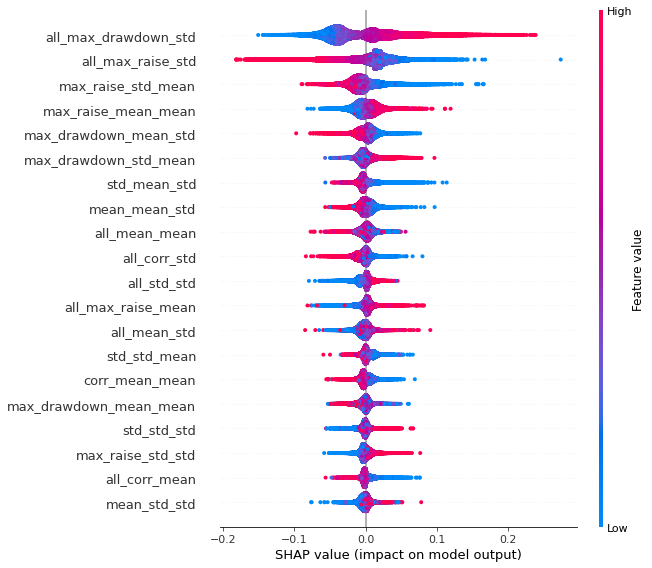

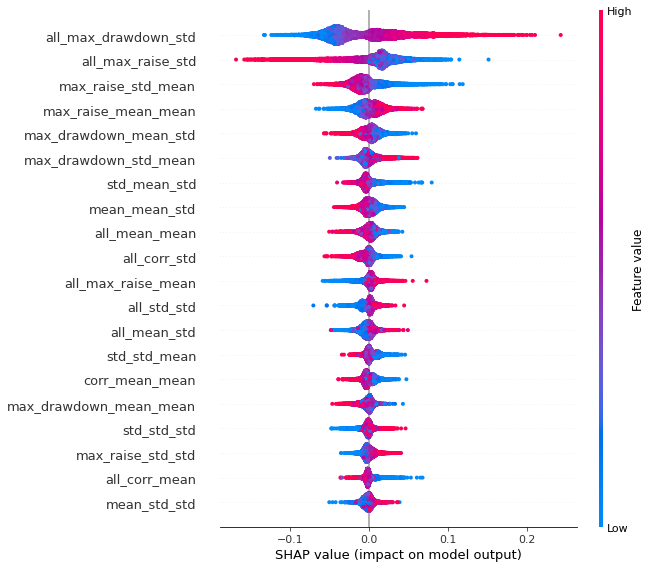

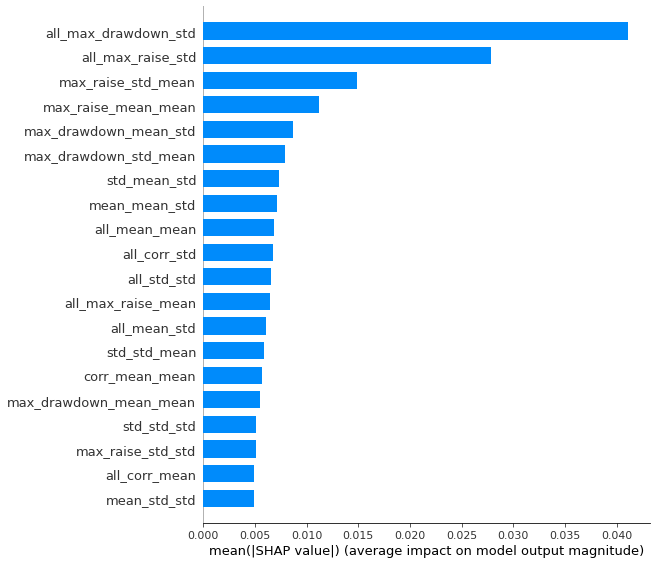

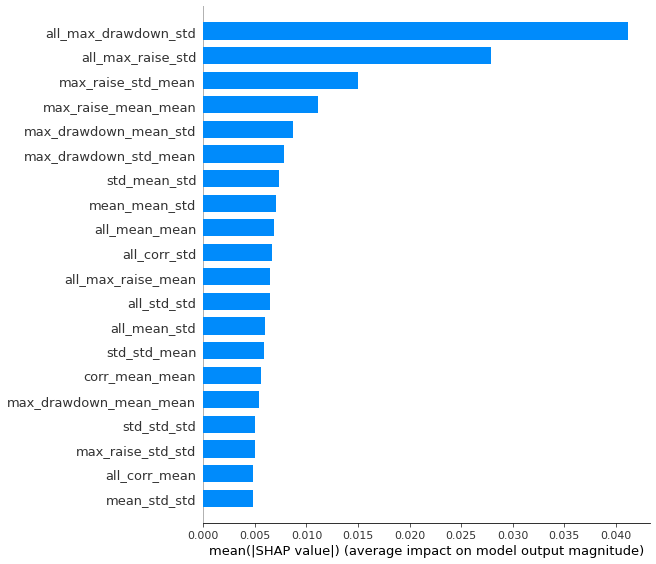

In [5]:
%time result = taskGraph.run()

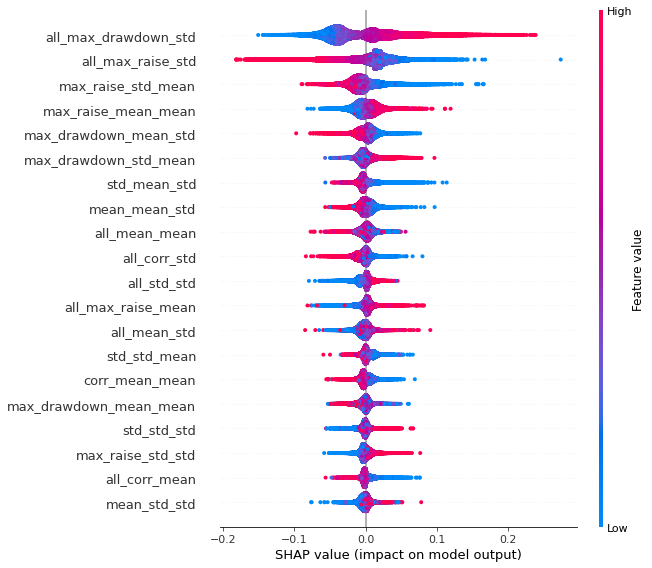

In [6]:
display(HTML('<h1>Shap Summary, Train</h1>'))
result['train_shap_dot.summary_plot']

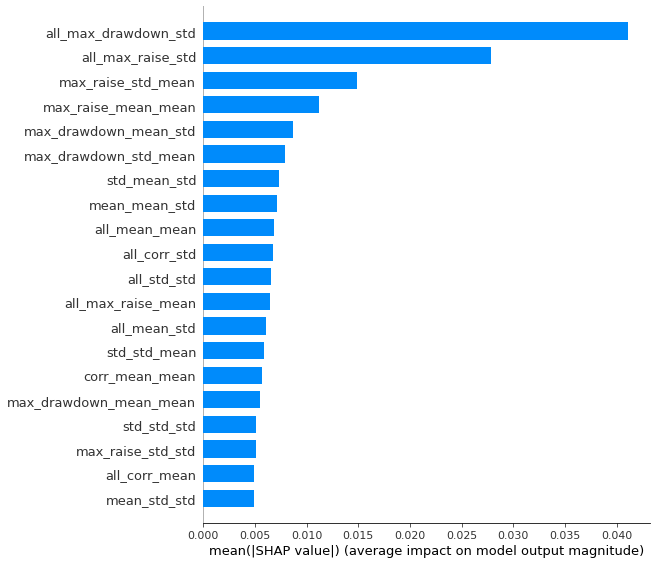

In [7]:
display(HTML('<h1>Shap Summary, Train</h1>'))
result['train_shap_bar.summary_plot']

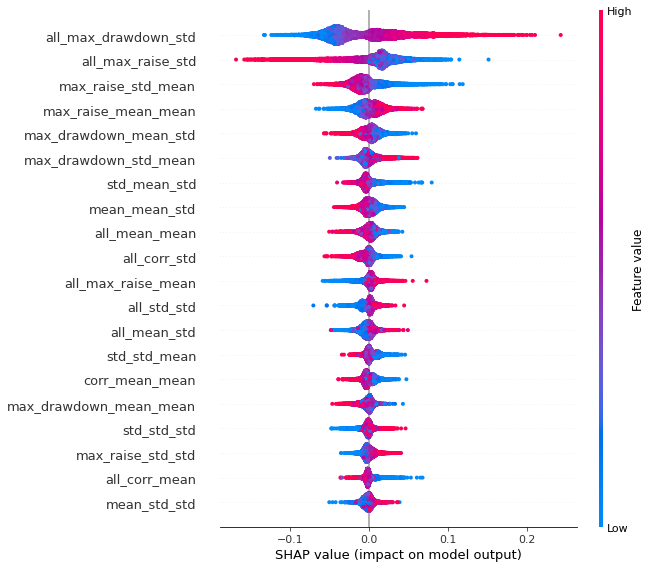

In [8]:
display(HTML('<h1>Shap Summary, Test</h1>'))
result['test_shap_dot.summary_plot']

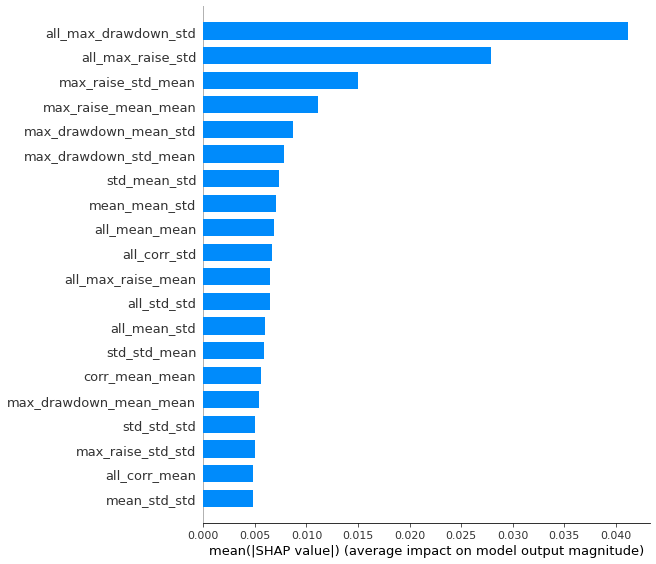

In [9]:
display(HTML('<h1>Shap Summary, Test</h1>'))
result['test_shap_bar.summary_plot']

We run the XGboost performance metrics again for 100K samples:

In [10]:
taskGraph=TaskGraph.load_taskgraph('./17assets/parallel_xgboost_performance.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

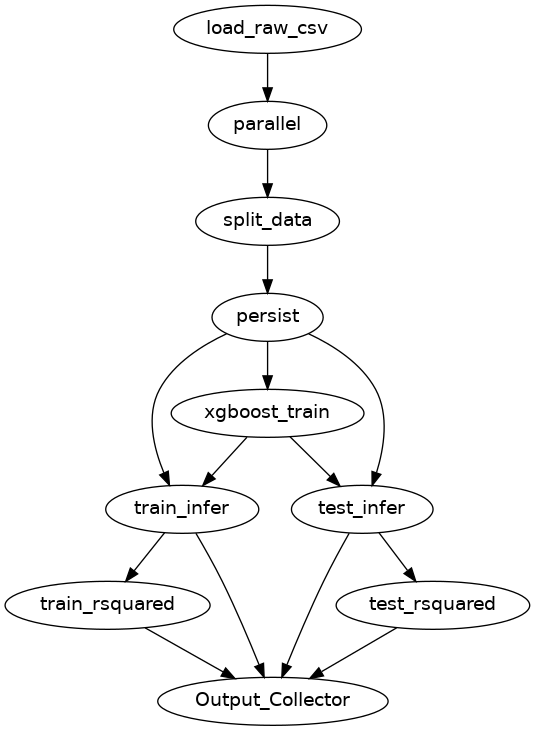

In [11]:
taskGraph.draw(show='ipynb')

In [12]:
%time result = taskGraph.run()

CPU times: user 12 s, sys: 2.22 s, total: 14.2 s
Wall time: 2min 34s


In [13]:
print('Train R-Squared:', result['train_rsquared.out'], 'Test R-Squared:', result['test_rsquared.out'])

Train R-Squared: 0.6353086806309562 Test R-Squared: 0.2309644451467247


In [14]:
train_infer_df = result['train_infer.out'].compute()
test_infer_df = result['test_infer.out'].compute()

Text(0.5, 1.0, 'Train')

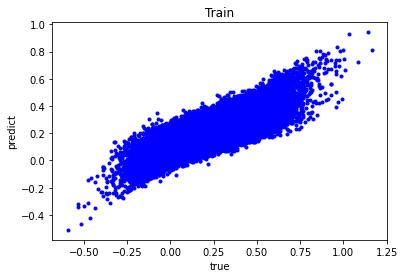

In [15]:
pl.plot(train_infer_df.portfolio.values.get(), train_infer_df.predict.values.get(), 'b.')
pl.xlabel('true')
pl.ylabel('predict')
pl.title('Train')

Text(0.5, 1.0, 'Test')

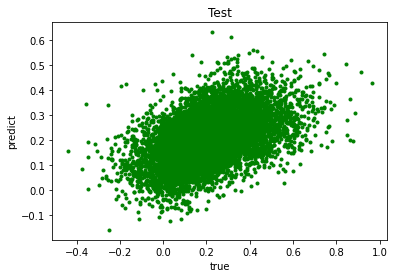

In [16]:
pl.plot(test_infer_df.portfolio.values.get(), test_infer_df.predict.values.get(), 'g.')
pl.xlabel('true')
pl.ylabel('predict')
pl.title('Test')

## Hyperparameter Optimization

When data scientists are building machine learning models, there are a few magic numbers that are included in the model. The example numbers are depths in the tree, the learning rate, etc. The parameters that define the model architecture or training process are usually referred to as hyperparameters. They are magical because there is no good theory about what number to choose. Commonly, the hyperparameters can be searched to find a good set of them that results in the best model performance. The process of searching is referred to as hyperparameter tuning.

There are a few popular Python-based hyperparameter tuning libraries existing: Ray Tune, Optuna, HyperOpt. Each library provides a set of search algorithms and schedule algorithms that is easy to use.

Inside the `greenflow` project, we implemented a Context Composite Node that can flexibly expose the hyperparameters that are interesting for tuning. The Context Composite Node makes hyperparameter tuning easy to do by leveraging the hyperparameter tuning libraries. Inside `greenflow_gquant_plugin` project, there is a `GridRandomSearchNode` that can do random and grid search with Ray Tune library for the hyperparameters. First, we need to initialize the ray tune environment.

In [17]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
# run this cell if you need Dask
from dask_cuda import LocalCUDACluster
import dask
dask.config.set({"distributed.comm.timeouts.tcp": "90s"})
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:41379 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 503.80 GiB


In [2]:
import cupy
import cudf
import matplotlib.pyplot as pl
from greenflow.dataframe_flow import TaskGraph
from IPython.display import display, HTML

In [3]:
import os
os.environ['RAY_OBJECT_STORE_ALLOW_SLOW_STORAGE'] = '1'

import ray
ray.init()

2021-09-15 00:41:37,157	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265
2021-09-15 00:41:37,161	WARNING services.py:1749 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 21474639872 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=22.00gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


{'node_ip_address': '10.31.229.54',
 'raylet_ip_address': '10.31.229.54',
 'redis_address': '10.31.229.54:6379',
 'object_store_address': '/tmp/ray/session_2021-09-15_00-41-35_558667_3283/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-09-15_00-41-35_558667_3283/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-09-15_00-41-35_558667_3283',
 'metrics_export_port': 55764,
 'node_id': '65eec786e51d3b1759a45c5a78a16a7b72a95659a19c9cb4a09bed95'}

Following is the workflow to run HPO. As a simple example, we will search the `num_rounds` and `eta` parameters in the XGBoost model. We use grid search for `num_rounds` and random search for `eta`. Click on the `GridRandomSearchNode`, you can see how we configure the search space.

In [4]:
taskGraph=TaskGraph.load_taskgraph('./17assets/hpo.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', 'xgboost_train'), ('type', 'ContextCompositeNode'), ('c…

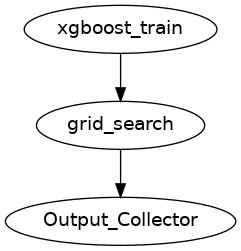

In [5]:
taskGraph.draw(show='ipynb')

In [6]:
taskGraph.run()

get best {'eta': 0.13169625125573148, 'num_rounds': 100}


Trial name,status,loc,eta,num_rounds
search_fun_b089e_00000,RUNNING,,0.110481,100
search_fun_b089e_00001,PENDING,,0.436578,110
search_fun_b089e_00002,PENDING,,0.263365,120


(pid=3617) Port 8787 is already in use.
(pid=3617) Perhaps you already have a cluster running?
(pid=3617) Hosting the HTTP server on port 39009 instead
(pid=3615) Port 8787 is already in use.
(pid=3615) Perhaps you already have a cluster running?
(pid=3615) Hosting the HTTP server on port 43543 instead


Trial name,status,loc,eta,num_rounds
search_fun_b089e_00000,RUNNING,,0.110481,100
search_fun_b089e_00001,RUNNING,,0.436578,110
search_fun_b089e_00002,PENDING,,0.263365,120


(pid=3617) start new Cluster
(pid=3615) start new Cluster


(pid=3615) [00:45:55] task [xgboost.dask]:tcp://127.0.0.1:46190 got new rank 0
(pid=3615) [00:45:55] task [xgboost.dask]:tcp://127.0.0.1:35911 got new rank 1
(pid=3615) [00:45:55] task [xgboost.dask]:tcp://127.0.0.1:44300 got new rank 2
(pid=3615) [00:45:55] task [xgboost.dask]:tcp://127.0.0.1:45880 got new rank 3
(pid=3617) [00:46:00] task [xgboost.dask]:tcp://127.0.0.1:37901 got new rank 0
(pid=3617) [00:46:00] task [xgboost.dask]:tcp://127.0.0.1:45805 got new rank 1
(pid=3617) [00:46:00] task [xgboost.dask]:tcp://127.0.0.1:36136 got new rank 2
(pid=3617) [00:46:00] task [xgboost.dask]:tcp://127.0.0.1:42137 got new rank 3


Result for search_fun_b089e_00001:
  date: 2021-09-15_00-46-02
  done: false
  experiment_id: b0ecd396a12d4797b6e9dcfc2cdb55df
  hostname: dgx04-contain
  iterations_since_restore: 1
  node_ip: 10.31.229.54
  pid: 3615
  test_rsquared.out: 0.20886621780068043
  time_since_restore: 259.37074398994446
  time_this_iter_s: 259.37074398994446
  time_total_s: 259.37074398994446
  timestamp: 1631666762
  timesteps_since_restore: 0
  train_rsquared.out: 0.7299008371376237
  training_iteration: 1
  trial_id: b089e_00001
  


Trial name,status,loc,eta,num_rounds,iter,total time (s),train_rsquared.out,test_rsquared.out
search_fun_b089e_00000,RUNNING,,0.110481,100,,,,
search_fun_b089e_00001,RUNNING,10.31.229.54:3615,0.436578,110,1,259.371,0.729901,0.208866
search_fun_b089e_00002,PENDING,,0.263365,120,,,,


Result for search_fun_b089e_00001:
  date: 2021-09-15_00-46-02
  done: true
  experiment_id: b0ecd396a12d4797b6e9dcfc2cdb55df
  experiment_tag: 1_eta=0.43658,num_rounds=110
  hostname: dgx04-contain
  iterations_since_restore: 1
  node_ip: 10.31.229.54
  pid: 3615
  test_rsquared.out: 0.20886621780068043
  time_since_restore: 259.37074398994446
  time_this_iter_s: 259.37074398994446
  time_total_s: 259.37074398994446
  timestamp: 1631666762
  timesteps_since_restore: 0
  train_rsquared.out: 0.7299008371376237
  training_iteration: 1
  trial_id: b089e_00001
  


(pid=3615) /home/quant/miniconda3/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 24 leaked semaphore objects to clean up at shutdown
(pid=3615)   warnings.warn('resource_tracker: There appear to be %d '


Result for search_fun_b089e_00000:
  date: 2021-09-15_00-46-07
  done: false
  experiment_id: b24df7326b29455fbf9cf74afdbc2296
  hostname: dgx04-contain
  iterations_since_restore: 1
  node_ip: 10.31.229.54
  pid: 3617
  test_rsquared.out: 0.26244257268797777
  time_since_restore: 264.0155813694
  time_this_iter_s: 264.0155813694
  time_total_s: 264.0155813694
  timestamp: 1631666767
  timesteps_since_restore: 0
  train_rsquared.out: 0.4799151971363568
  training_iteration: 1
  trial_id: b089e_00000
  
Result for search_fun_b089e_00000:
  date: 2021-09-15_00-46-07
  done: true
  experiment_id: b24df7326b29455fbf9cf74afdbc2296
  experiment_tag: 0_eta=0.11048,num_rounds=100
  hostname: dgx04-contain
  iterations_since_restore: 1
  node_ip: 10.31.229.54
  pid: 3617
  test_rsquared.out: 0.26244257268797777
  time_since_restore: 264.0155813694
  time_this_iter_s: 264.0155813694
  time_total_s: 264.0155813694
  timestamp: 1631666767
  timesteps_since_restore: 0
  train_rsquared.out: 0.479915

(pid=3613) Port 8787 is already in use.
(pid=3613) Perhaps you already have a cluster running?
(pid=3613) Hosting the HTTP server on port 41438 instead
(pid=3617) /home/quant/miniconda3/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 24 leaked semaphore objects to clean up at shutdown
(pid=3617)   warnings.warn('resource_tracker: There appear to be %d '


(pid=3613) start new Cluster


(pid=3613) [00:49:16] task [xgboost.dask]:tcp://127.0.0.1:35082 got new rank 0
(pid=3613) [00:49:16] task [xgboost.dask]:tcp://127.0.0.1:32975 got new rank 1
(pid=3613) [00:49:16] task [xgboost.dask]:tcp://127.0.0.1:33483 got new rank 2
(pid=3613) [00:49:16] task [xgboost.dask]:tcp://127.0.0.1:37499 got new rank 3


Result for search_fun_b089e_00002:
  date: 2021-09-15_00-49-23
  done: false
  experiment_id: ff2c2c6358314ff2944a719b3da70f07
  hostname: dgx04-contain
  iterations_since_restore: 1
  node_ip: 10.31.229.54
  pid: 3613
  test_rsquared.out: 0.2440717036000372
  time_since_restore: 196.79628109931946
  time_this_iter_s: 196.79628109931946
  time_total_s: 196.79628109931946
  timestamp: 1631666963
  timesteps_since_restore: 0
  train_rsquared.out: 0.656421922676001
  training_iteration: 1
  trial_id: b089e_00002
  


Trial name,status,loc,eta,num_rounds,iter,total time (s),train_rsquared.out,test_rsquared.out
search_fun_b089e_00002,RUNNING,10.31.229.54:3613,0.263365,120,1,196.796,0.656422,0.244072
search_fun_b089e_00000,TERMINATED,,0.110481,100,1,264.016,0.479915,0.262443
search_fun_b089e_00001,TERMINATED,,0.436578,110,1,259.371,0.729901,0.208866


Result for search_fun_b089e_00002:
  date: 2021-09-15_00-49-23
  done: true
  experiment_id: ff2c2c6358314ff2944a719b3da70f07
  experiment_tag: 2_eta=0.26336,num_rounds=120
  hostname: dgx04-contain
  iterations_since_restore: 1
  node_ip: 10.31.229.54
  pid: 3613
  test_rsquared.out: 0.2440717036000372
  time_since_restore: 196.79628109931946
  time_this_iter_s: 196.79628109931946
  time_total_s: 196.79628109931946
  timestamp: 1631666963
  timesteps_since_restore: 0
  train_rsquared.out: 0.656421922676001
  training_iteration: 1
  trial_id: b089e_00002
  


Trial name,status,loc,eta,num_rounds,iter,total time (s),train_rsquared.out,test_rsquared.out
search_fun_b089e_00000,TERMINATED,,0.110481,100,1,264.016,0.479915,0.262443
search_fun_b089e_00001,TERMINATED,,0.436578,110,1,259.371,0.729901,0.208866
search_fun_b089e_00002,TERMINATED,,0.263365,120,1,196.796,0.656422,0.244072


2021-09-15 00:49:23,325	INFO tune.py:561 -- Total run time: 463.69 seconds (463.33 seconds for the tuning loop).
(pid=3613) /home/quant/miniconda3/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 24 leaked semaphore objects to clean up at shutdown
(pid=3613)   warnings.warn('resource_tracker: There appear to be %d '


Results([('grid_search.conf_out', <greenflow.plugin_nodes.util.data_obj.ConfData object at 0x7f95b90dbd60>), ('grid_search.test_rsquared@out', 0.2718288848038828)])

In above simple HPO run, we see more rounds in the XGBoost training help to increase the test R-squared score. HPO is a time consuming process, GPU make it possible as we reduce the time to run 100K bootstrap samples from days in CPU cluster to 4 mins in DGX station. Feel free to add more hyperparamerters and increase the number of trails in above workflow.

## Scale to 1 million Samples

As the last part of this notebook, let's scale the computation to 1 million bootstrap samples. Ideall, the computation should scale linearly. We use the same taskgraph but increase the number or iterations 10 fold.

In [7]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
# run this cell if you need Dask
from dask_cuda import LocalCUDACluster
import dask
dask.config.set({"distributed.comm.timeouts.tcp": "90s"})
cluster = LocalCUDACluster()
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:45651 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 503.80 GiB


In [2]:
import cupy
import cudf
import matplotlib.pyplot as pl
from greenflow.dataframe_flow import TaskGraph
from IPython.display import display, HTML

In [3]:
taskGraph=TaskGraph.load_taskgraph('./17assets/parallel_xgboost_shap.gq.yaml')
taskGraph.draw()

GreenflowWidget(sub=HBox(), value=[OrderedDict([('id', ''), ('type', 'Output_Collector'), ('conf', {}), ('inpu…

CPU times: user 2min 14s, sys: 19.2 s, total: 2min 33s
Wall time: 17min 38s


Results([('train_shap_dot.summary_plot', <Figure size 576x684 with 2 Axes>), ('test_shap_dot.summary_plot', <Figure size 576x684 with 2 Axes>), ('train_shap_bar.summary_plot', <Figure size 576x684 with 1 Axes>), ('test_shap_bar.summary_plot', <Figure size 576x684 with 1 Axes>)])

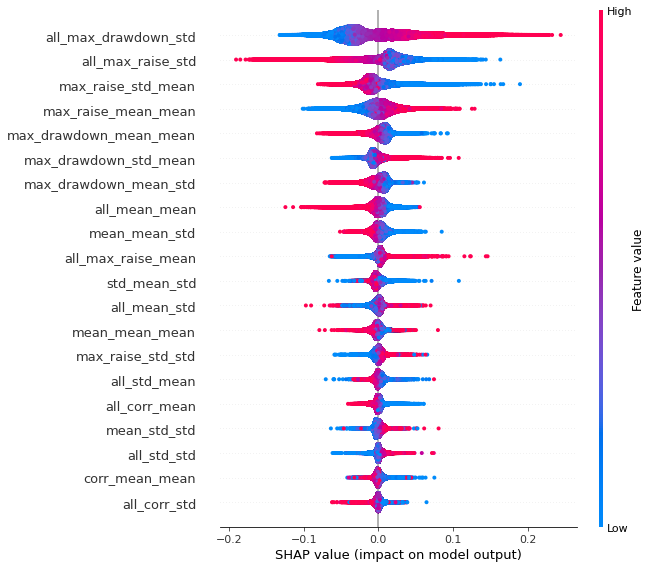

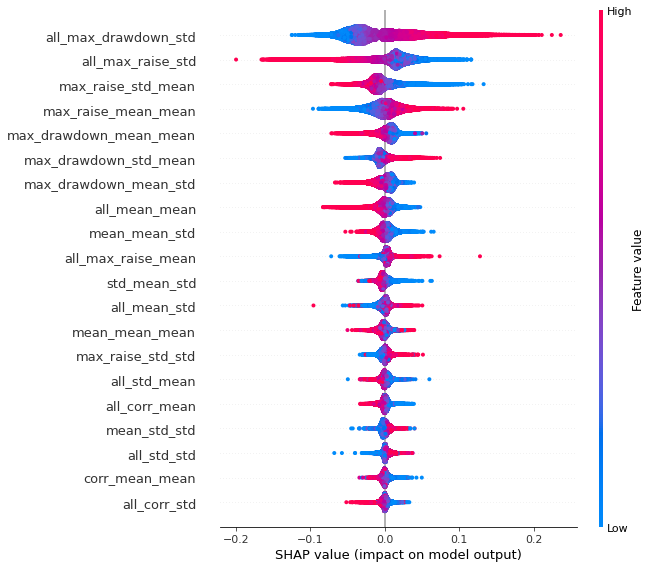

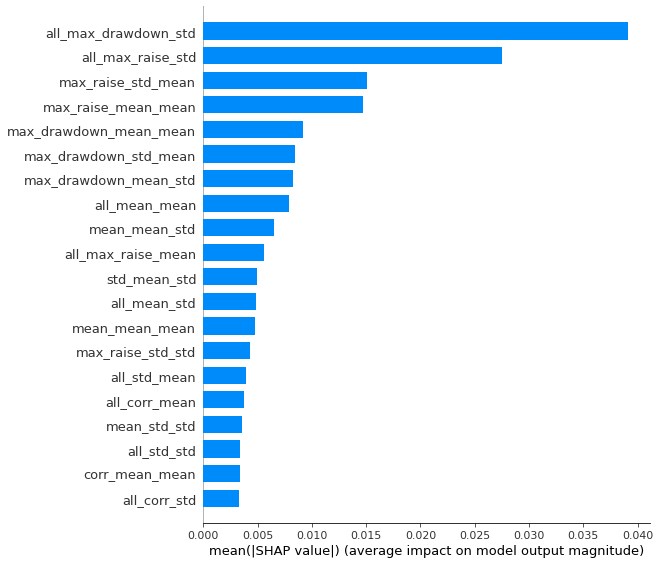

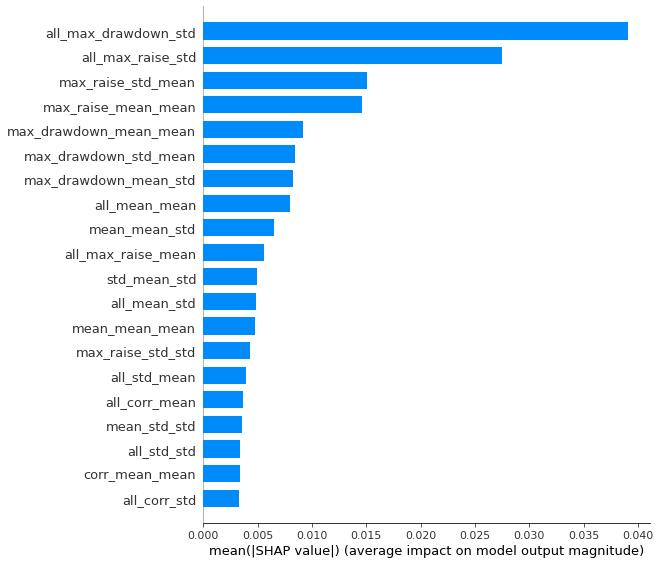

In [4]:
%%time
taskGraph.run(replace={
    "parallel" : {
        "conf": {
            "input": ["bootstrap.in"],
            "output": ["merge_target.merged"],
            "map": [{"node_id": "bootstrap",
                     "xpath": "bootstrap.conf.offset"
                    }],
            "taskgraph": "notebooks/17assets/full_workflow_xgboost_performance.gq.yaml",
            "iterations": 250
        }
    }
})